In [2]:
using Plots
theme(:dark)

# Machine Epsilon and Roundoff Error.
For 64-bit memory, example Float64, we have 16 digits of accuracy: However, the exact epsilon is relative and will change as we scale the value we want to reference.

In [3]:
eps(Float64)

2.220446049250313e-16

In [4]:
@show eps(1.0)
@show eps(0.1)
@show eps(0.01);

eps(1.0) = 2.220446049250313e-16
eps(0.1) = 1.3877787807814457e-17
eps(0.01) = 1.734723475976807e-18


The expression $(x+\epsilon) - x$ should $=\epsilon$, if there were no roundoff error. But if $\epsilon$ is small this can start to effect our expression. If x is order 1, and $\epsilon$ is order $10^{-10}$, then $x+\epsilon$ is correct for 10 digits, dropping of the smallest 10 due ot error in the addition to 1. But when you subtract x again, we don't get those digits back! 

### in code:

In [5]:
error = 1e-10rand()
@show error;

error = 8.016219007840449e-11


In [6]:
@show 1+error;
#we are not keeping all the digits, just 84732! What about the rest?!

1 + error = 1.000000000080162


In [7]:
#This should be 0! Buttt its not :( 
1+error - 1 - error

-9.089757953782414e-17

# Finite Differencing and Numerical Stability
$$f^{\prime}(x)=\lim _{\epsilon \rightarrow \infty} \frac{f(x+\epsilon)-f(x)}{\epsilon}$$

# Numerically Solving Ordinary Differential Equations
$$f(u, p, t)=u^{\prime}=\frac{d u}{d t} \approx \frac{\Delta u}{\Delta t}$$
and defining $\Delta u=u_{n+1}-u_{n}$, we have:
$$\Delta t f(u, p, t)=u_{n+1}-u_{n}$$
and thus we have $\textbf{Euler's Method}$:
$$u_{n+1}=u_{n}+\Delta t f(u, p, t)$$

As an example, lets use:

$$\frac{dP}{dt} = kP$$

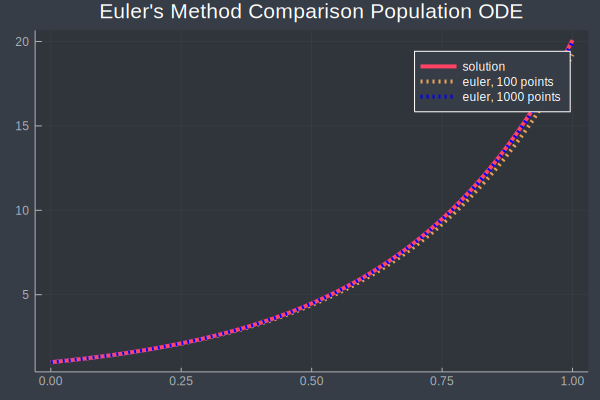

In [8]:
function population(x,y, params)
    k = params[1]
    return k*y
end

function euler(f, u0, tspan, N, params)
    
    t0 = [0.]
    dt = (tspan[2]-tspan[1])/N

    for i in 1:N    
        append!(u0, u0[end]+dt*f(t0[end], u0[end], params))
        append!(t0, t0[end]+dt)
    end
    return t0, u0  
end

x,y = euler(population, [1.], (0,1), 100, [3.])
plot(x, exp.(3*x), label="solution", linewidth = 4, title="Euler's Method Comparison Population ODE")
plot!(x,y, label="euler, 100 points", linewidth = 4, linestyle = :dot)
x,y = euler(population, [1.], (0,1), 1000, [3.])
plot!(x,y, label="euler, 1000 points", linewidth = 4, linestyle = :dot, linecolor=:blue)

# A higher order method:
$$u_{n+1}=u_{n}+\Delta t f\left(t+\frac{\Delta t}{2}, u_{n}+\frac{\Delta t}{2} f_{n}\right)$$

This is called a runge-kutta method, this specifically is RK3, there are much higher order runge-kutta methods.

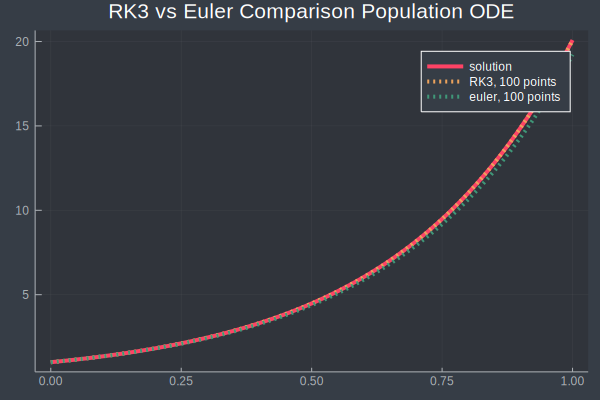

In [9]:
function RK3(f, u0, tspan, N, params)

    t0 = [0.]


    dt = (tspan[2]-tspan[1])/N

    for i in 1:N    
        append!(u0, u0[end]+dt*f(t0[end] + dt/2, u0[end] + (dt/2)* f(t0[end], u0[end],params), params))
        append!(t0, t0[end]+dt)
    end
    
    return t0, u0
    
end

x,y = RK3(population, [1.], (0,1), 100, [3.])
plot(x, exp.(3*x), label="solution", linewidth = 4, title="RK3 vs Euler Comparison Population ODE")
plot!(x,y, label="RK3, 100 points", linewidth = 4, linestyle = :dot)
x,y = euler(population, [1.], (0,1), 100, [3.])
plot!(x,y, label="euler, 100 points", linewidth = 4, linestyle = :dot)

## Lets try a second order ODE
Where $$\frac{d^2x}{dt^2} = f(t,x,\frac{dx}{dt})$$

We can break up our problem into two first order ODEs!
$$\left\{\begin{array}{l}\dot{x}=u \\ \dot{u}=f(t, x, u)\end{array}\right.$$


Lets do a spring:
$$\frac{d^2x}{dt^2} = -\frac{k}{m}x$$

In [10]:
function spring(t, u, uprime, params)
    k = params[1]
    m = params[2]
    return -(k/m)*u
end

function second_order_euler(f, u0, u0prime, tspan, N, params)

    t0 = [0.]
    dt = (tspan[2]-tspan[1])/N

    for i in 1:N    
        #break it into two first order ODEs
        #  u' = v
        #  v' = f(t,u,u')
        
        append!(u0prime, u0prime[end]+dt*f(t0[end], u0[end], u0prime[end], params))
        append!(u0, u0[end]+dt*u0prime[end])
        #Time step
        append!(t0, t0[end]+dt)
    end
    return t0, u0, u0prime
end

#Exact solution u0cos(wt) + (v0/w)sin(wt)
params = [3.0, .5]
u0 = [1.0]
v0 = [1.0]
ω = sqrt(params[1]/params[2])
plot(t, u0.*cos.(ω*t) + (v0/ω).*sin.(ω*t), label="Exact Solution", linewidth = 4)



params = [3.0, .5]
u0 = [1.0]
v0 = [1.0]
t, x, v = second_order_euler(spring, u0, v0, (0,10), 1000, params)
plot!(t,x, label="N=1000",linewidth = 4, linestyle = :dot)


params = [3.0, .5]
u0 = [1.0]
v0 = [1.0]
t, x, v = second_order_euler(spring, u0, v0, (0,10), 100, params)
plot!(t,x, label="N=100",linewidth = 4, linestyle = :dot, title="Simple Harmonic Oscillator, Second Order Euler")



UndefVarError: UndefVarError: t not defined

# Stiff ODEs
Some ODEs are "stiff" meaning a fixed timestep won't work well unless it's extremely small. Usually there is a region that requires this, with quick oscillations, but in order to capture this behavior, with fixed timestep methods, we need to use this small timestep for the entire problem. Stiff ODEs are generally unstable with small number of steps as seen below

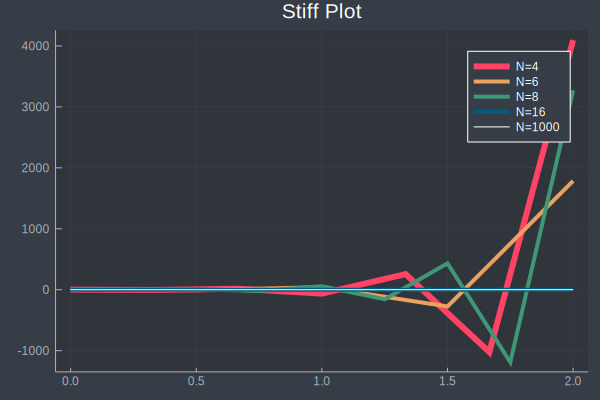

In [11]:
function a_stiff_ode(t, u, uprime)
    return -15*u
end

t,x = euler(a_stiff_ode, [1.], (0,2), 6, [3.])
plot(t,x, label="N=4", linewidth=6)


t,x = euler(a_stiff_ode, [1.], (0,2), 4, [3.])
plot!(t,x, label="N=6", linewidth=4)

t,x = euler(a_stiff_ode, [1.], (0,2), 8, [3.])
plot!(t,x, label="N=8",linewidth=4)


t,x = euler(a_stiff_ode, [1.], (0,2), 16, [3.])
plot!(t,x, label="N=16", linewidth=4)


t,x = euler(a_stiff_ode, [1.], (0,2), 1000, [3.])
plot!(t,x, label="N=1000",title="Stiff Plot", color=:white)

Good thing there are stiff ODE methods!

First a detour to implicit euler:
Implicit ODE solvers use the current state in the update $u_{k+1} = f(..., u_{k+1}) $, rather than soley the previous information $u_{k+1} = f(..., u_{k}) $, This could help us with stiff methods, because we have some incoded information about the next step :)

Let's implement implicit euler, then look at how it can help us solve stiff ODEs.

## Implicit Euler:
$$y_{n+1}=y_{n}+h f\left(t_{n+1}, y_{n+1}\right)$$

(compared to explicit euler): $y_{n+1}=y_{n}+h f\left(t_{n}, y_{n}\right)$

But... how do we get $y_{n+1}$ then? The answer is we must solve for it!

Lets look at an example to make this a little more clear.

Ex: $y' = f(t,y) = sin(y)$

So in terms of implicit euler:

$y_{n+1} = sin(y_{n+1})$

Solve for $y_{n+1}$. 

SO we need a root solver... if we're going to use implicit euler

## Newton's Method:
Solve for zeros of a function!
Repeat until desired tollerance is reached:
$$x_{n+1}=x_{n}-\frac{f\left(x_{n}\right)}{f^{\prime}\left(x_{n}\right)}$$

WE CAN USE AUTOMATIC DIFFERENTIATION FOR THE DERIVATIVE!! (See previous lecture) Luckily julia has this built in ;)

Newton's Method Example:

In [12]:
using ForwardDiff


function squared(x)
    x^2
end

function newton_method(f,x0,tolerance)
    #f(x0) should -> 0
    while f(x0) > tolerance
        x0 = x0 - f(x0)/ForwardDiff.derivative(f,x0)
    end
    return x0
end

newton_method(squared, 3.0, 0.001)

0.0234375

Now that we have a working newton's method, lets do implicit euler:
$$y_{n+1}=y_{n}+dt* f\left(t_{n+1}, y_{n+1}\right)$$

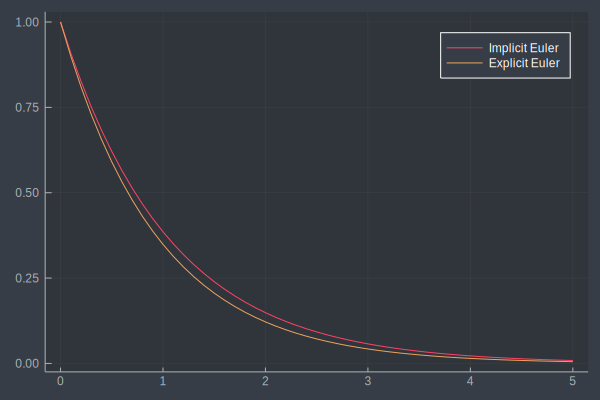

In [47]:
function implicit_euler(f, u0, tspan, N, params)
    t0 = [0.]
    dt = (tspan[2]-tspan[1])/N
    
    for i in 1:N
        u_new = newton_method(yn -> u0[end] + dt*f(t0[end]+dt, yn, params) - yn,
                             -4.0, 0.0001)
        #u_new = 1/(1+dt)*f(t0[end]+dt, u0[end], params)
        append!(u0, u_new)
        #append!(u0, u0[end]/(1+dt*params[1]))
        append!(t0, t0[end]+dt)
    end
    return t0, u0
end

function func(t,x, params)
    k = params[1]
    return -x*k
end


#Comparing implicit euler to explicit euler...

t,x = implicit_euler(func, [1.0], (0,5), 50, [1.0])

plot(t,x, label="Implicit Euler")

t,x = euler(func, [1.0], (0,5), 50, [1.0])
plot!(t,x, label="Explicit Euler")

## But what happens if we reduce the steps? Explicit Euler is unstable!!! Lets see what happens in this case

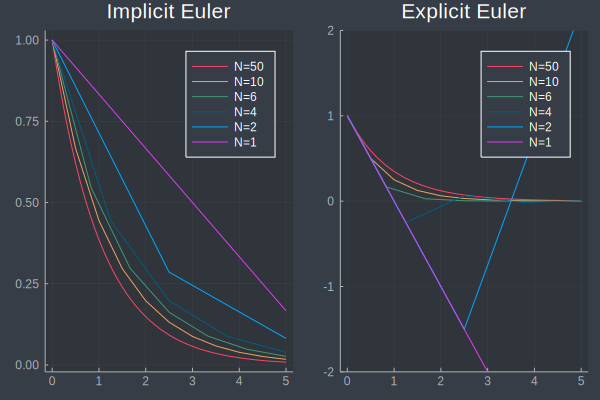

In [72]:
#IMPLICIT EULER:
t,x = implicit_euler(func, [1.0], (0,5), 50, [1.0])
implicit = plot(t,x, label="N=50")
t,x = implicit_euler(func, [1.0], (0,5), 10, [1.0])
plot!(t,x, label="N=10")
t,x = implicit_euler(func, [1.0], (0,5), 6, [1.0])
plot!(t,x, label="N=6")
t,x = implicit_euler(func, [1.0], (0,5), 4, [1.0])
plot!(t,x, label="N=4")
t,x = implicit_euler(func, [1.0], (0,5), 2, [1.0])
plot!(t,x, label="N=2")
t,x = implicit_euler(func, [1.0], (0,5), 1, [1.0])
plot!(t,x, label="N=1", title="Implicit Euler")

#EXPLICIT EULER:
t,x = euler(func, [1.0], (0,5), 50, [1.0])
explicit = plot(t,x,label="N=50")
t,x = euler(func, [1.0], (0,5), 10, [1.0])
plot!(t,x, label="N=10")
t,x = euler(func, [1.0], (0,5), 6, [1.0])
plot!(t,x, label="N=6")
t,x = euler(func, [1.0], (0,5), 4, [1.0])
plot!(t,x, label="N=4")
t,x = euler(func, [1.0], (0,5), 2, [1.0])
plot!(t,x, label="N=2")
t,x = euler(func, [1.0], (0,5), 1, [1.0])
plot!(t,x, label="N=1", title="Explicit Euler", ylim=(-2,2))


plot(implicit, explicit, layout = (1, 2))

# Implicit Euler is nice and stable :) This works for stiff ODEs!!

In our implementation of implicit euler, we used newton's method which uses ForwardDiff.derivative. This works for 1d, however in general, we need a jacobian to do this calculation.

Implicit Euler's Method:
$$u_{n+1}=u_{n}+\Delta t f\left(u_{n+1}, t+\Delta t\right)$$
Rearranging:
$$u_{n+1}-\Delta t f\left(u_{n+1}, t+\Delta t\right)-u_{n}=0$$
Which is a root finding problem:
$$g(u_{n+1})=0$$

Newton's method in general is:
$$
x_{k+1}=x_{k}-J\left(x_{k}\right)^{-1} g\left(x_{k}\right)
$$
where J is the jacobian of $g$ at point $x_k$

Inverses are expensiveeeeee! We can rewrite this into two steps to make it more efficient (because in general the jacobian is sparse): Turning the inverse problem into a linear solve and update. 

$$
\begin{array}{l}\text { Solve } J a=g\left(x_{k}\right) \text { for } a \\ \text { Update } x_{k+1}=x_{k}-a\end{array}
$$